In [987]:
"""
    Objective 1: Lab data
        - Plot the data
        - Check average performance (binnned) increases w/ delta -> RM-ANOVA
        - Both for orientation and color
    Objective 2: mturk data
        - Bootstrap samples to compute standard error
        - relevant data: check average performance (binned) increases w/ delta -> RM-ANOVA
        - Irrelevant data: check average performance (binned) is 
            significantly different from chance -> one-sided t-test
    Objective 3: Lab vs. mturk data (relevant)
        - Check mturk data is significanlty worse than lab data -> two-sided t-test
"""
import fnmatch # file name matching
import os
from scipy.io import loadmat

from pandas import DataFrame, Series
import pandas as pd
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

# Change font setting
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

#1. Laboratory experiment
## Change localization w/ one orientation change and one color change (N = 5)
##1.1 Load files

In [988]:
""" Define path name and subject names """
pathname = 'one_change_lab/'
file_names = os.listdir(pathname)
subject_names = ['HJK','HS0','LLT','WK0','WZ0']

In [989]:
""" Create a DataFrame for all subject data """
index = 1
# Loop over subjects (subject_names)
df = DataFrame()
for index in [1,2]:
    temp2 = DataFrame()
    for subject_name in subject_names:
        # Create a tag to find files based on a subject name
        subject_tag = subject_name + '6_6_' + str(index)
        # Filter the files
        subject_files = fnmatch.filter(file_names, subject_tag + '*.mat')
        # Loop over filtered files
        temp1 = DataFrame()
        for subject_file in subject_files:
            # Convert a MATLAB matrix to a DataFrame
            temp0 = DataFrame(loadmat(pathname+subject_file)['datamatrix'])
            # Concatenate DataFrames
            temp1 = pd.concat([temp1,temp0],ignore_index=True)
        # Create a column to assign subject names
        temp1['Name'] = DataFrame([subject_name]*len(temp1))
        # Concatenate
        temp2 = pd.concat([temp2,temp1],ignore_index=True)
        # Create a column to assign experiment index
        if index == 1:
            temp2['Feature'] = DataFrame(['Ori']*len(temp2))
        elif index == 2:
            temp2['Feature'] = DataFrame(['Col']*len(temp2))
    # Concatenate all subject data to create a single DataFrame            
    df = pd.concat([df,temp2],ignore_index=True)

###<font color='red'>Orientation: delta = column 1, Color: delta = column 2

In [990]:
df_temp = df[['Name','Feature',1,2,8]]
df_ori = df_temp.loc[:len(df_temp)/2-1,['Name','Feature',1,8]]
df_col = df_temp.loc[len(df_temp)/2:,['Name','Feature',2,8]]
print df_ori.tail()
print df_col.head()

     Name Feature          1  8
2995  WZ0     Ori -62.423398  1
2996  WZ0     Ori  65.431755  1
2997  WZ0     Ori   2.256267  0
2998  WZ0     Ori -48.885794  1
2999  WZ0     Ori -80.473538  0
     Name Feature    2  8
3000  HJK     Col   78  1
3001  HJK     Col  314  0
3002  HJK     Col  199  0
3003  HJK     Col  101  1
3004  HJK     Col   66  1


In [991]:
# Assign column names
df_ori.columns = ['Subject', 'Feature','Delta','Correct']
df_col.columns = ['Subject', 'Feature','Delta','Correct']

##1.2 Remap the delta for color data

In [992]:
"""
    Remapping color change magnitude
    Original range: range(1,361)
    Remap:
        1, ... 180: delta
        181, ..., 360: 360 - delta
    df['c'+str(i+1)] = df['C'+str(i+1)].apply((lambda x: hextorgb(x)))

"""
def remap_colors(old_delta):
    if old_delta <= 180:
        new_delta = old_delta
    else:
        new_delta = 360 - old_delta
    if new_delta == 0:
        new_delta = 0.0001
    else:
        new_delta = new_delta/2.0
    return new_delta
# remap
df_col.Delta = df_col.loc[:,'Delta'].apply((lambda x: remap_colors(x)))

In [993]:
df_col.describe()

,Delta,Correct
count,3000.000000,3000.000000
mean,45.836333,0.716667
std,26.191319,0.450692
min,0.000100,0.000000
25%,23.000000,0.000000
50%,46.000000,1.000000
75%,68.500000,1.000000
max,90.000000,1.000000


In [994]:
# Concatenate
df_short = pd.concat([df_ori,df_col],ignore_index=True)
df_short.head()

,Subject,Feature,Delta,Correct
0,HJK,Ori,88.997214,1
1,HJK,Ori,-15.793872,0
2,HJK,Ori,85.487465,1
3,HJK,Ori,-56.406685,1
4,HJK,Ori,-57.409471,1


##1.3 Bin the data based on the change magnitude (delta)

###<font color='red'>Adding new columns to a df -> Use df.loc[:,new_column_name] = value

###<font color='red'>Selecting cells based on location  -> Use df.iloc[list or int,list or int] = value

In [995]:
"""
    Objective: Binning the data
    1. Get absolute values of delta
    2. Create index for delta
    3. Create an column
    4. Groupby
"""
#1. Get absolute values of delta and add it as a new column
df_short.loc[:,'AbsDelta']=abs(df_short['Delta'].values)

In [996]:
#2. Creat a new index based on bin size
def label_bin(data,n_bins):
    # takes data and bin size as input, and gives labels to each data point based on histogram results
    bins = np.linspace(round(min(data)),round(max(data)),n_bins)
    # right=True: the intervals include the right or the left bin edge. 
    # Digitize default behavior (right==False): does not include right edge
    inds = np.digitize(data, bins, right=True)
    return bins, inds

bins, inds = label_bin(df_short.AbsDelta,10)
print 'bins=' + str(bins)

# Double check if the sum of the inds in each bin is the number of the total data points
tot = 0
for i in range(min(inds),max(inds)+1):
    print 'ind(' + str(i) + ')=' + str(np.shape(np.where(inds==i))[1])
    tot += np.shape(np.where(inds==i))[1]
print 'total = ' + str(tot)

bins=[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]
ind(1)=633
ind(2)=690
ind(3)=635
ind(4)=679
ind(5)=681
ind(6)=636
ind(7)=695
ind(8)=637
ind(9)=714
total = 6000


In [997]:
#3. Add this as a new column
df_short.loc[:,'DeltaInd']=inds

In [998]:
df_short.head()

,Subject,Feature,Delta,Correct,AbsDelta,DeltaInd
0,HJK,Ori,88.997214,1,88.997214,9
1,HJK,Ori,-15.793872,0,15.793872,2
2,HJK,Ori,85.487465,1,85.487465,9
3,HJK,Ori,-56.406685,1,56.406685,6
4,HJK,Ori,-57.409471,1,57.409471,6


##1.4 Compute summary statistics

In [999]:
"""
    Use Pandas groupby to compute statistics easily
"""
grouped = df_short.groupby(['Feature','DeltaInd'])
df_mean = grouped.mean()
df_ste = grouped.std()/np.sqrt(len(subject_names))

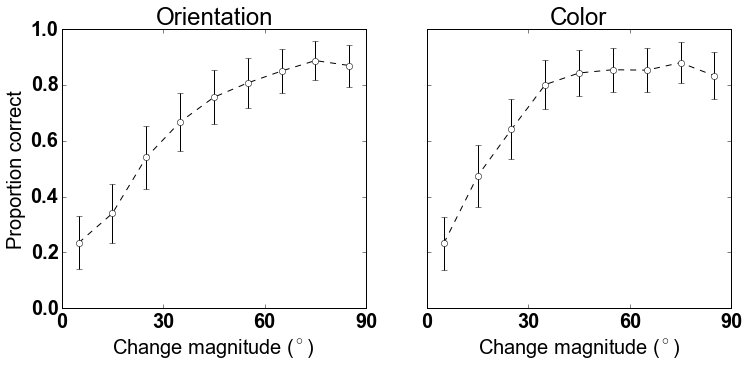

In [1000]:
"""
    Draw plots
    Simple way of calling groups: ex) df_mean.Correct.Ori
"""

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
fig.set_size_inches(12, 5)

# Choose a mid-point of each bin for plotting
bins_loc = bins[:-1]+np.diff([bins[0],bins[1]])/2

# Draw mean with errors
ax1.errorbar(bins_loc,df_mean.Correct.Ori,yerr=df_ste.Correct.Ori/2, color='black', fmt='o--', mfc='white')
ax2.errorbar(bins_loc,df_mean.Correct.Col,yerr=df_ste.Correct.Col/2, color='black', fmt='o--', mfc='white')

# Axes
plt.ylim(0,1)
ax1.set_xticks([0,30,60,90])
ax2.set_xticks([0,30,60,90])

# Labels
ax1.set_ylabel('Proportion correct')
ax1.set_title('Orientation')
ax1.set_xlabel('Change magnitude ($^\circ$)')
ax2.set_title('Color')
ax2.set_xlabel('Change magnitude ($^\circ$)')

plt.show()

#2. Mturk experiment
## Change localization w/ one orientation change and one color change (N = 5)
##2.1 Load files

In [1001]:
pathname_mturk = 'mturk_CL/'
file_names_mturk = os.listdir(pathname_mturk)
print file_names_mturk

['mturk_col.mat', 'mturk_ori.mat']


In [1002]:
mturk_Ori = loadmat(pathname_mturk+file_names_mturk[1])
mturk_Col = loadmat(pathname_mturk+file_names_mturk[0])
print 'Ori: ' + str(mturk_Ori.keys())
print 'Col: ' + str(mturk_Col.keys())

Ori: ['DeltaOri_expOri', '__header__', '__globals__', 'Perf_expOri', '__version__', 'DeltaCol_expOri']
Col: ['__globals__', 'DeltaCol_expCol', '__header__', 'DeltaOri_expCol', 'Perf_expCol', '__version__']


In [1003]:
df_DeltaOri_Ori = DataFrame(mturk_Ori['DeltaOri_expOri'])
df_DeltaCol_Ori = DataFrame(mturk_Ori['DeltaCol_expOri'])
df_Perf_Ori = DataFrame(mturk_Ori['Perf_expOri'])

df_DeltaCol_Col = DataFrame(mturk_Col['DeltaCol_expCol'])
df_DeltaOri_Col = DataFrame(mturk_Col['DeltaOri_expCol'])
df_Perf_Col = DataFrame(mturk_Col['Perf_expCol'])

df_list_Ori = [df_DeltaOri_Ori,df_Perf_Ori,df_DeltaCol_Ori]
df_list_Col = [df_DeltaCol_Col,df_Perf_Col,df_DeltaOri_Col]

# Check the size of df
print 'np.shape(DeltaOri_Ori):'+str(np.shape(df_DeltaOri_Ori))
print 'np.shape(DeltaCol_Ori):'+str(np.shape(df_DeltaCol_Ori))
print 'np.shape(Perf_Ori):'+str(np.shape(df_Perf_Ori))
print 'np.shape(DeltaCol_Col):'+str(np.shape(df_DeltaCol_Col))
print 'np.shape(DeltaOri_Col):'+str(np.shape(df_DeltaOri_Col))
print 'np.shape(Perf_Col):'+str(np.shape(df_Perf_Col))

np.shape(DeltaOri_Ori):(663, 30)
np.shape(DeltaCol_Ori):(663, 30)
np.shape(Perf_Ori):(663, 31)
np.shape(DeltaCol_Col):(769, 30)
np.shape(DeltaOri_Col):(769, 30)
np.shape(Perf_Col):(769, 31)


In [1004]:
# We are pooling data across trials and subjects for relevant data -> Concatenate
n_sbj = 600

In [1005]:
# Concatenate performance columns
df = df_list_Ori[1]
df_po = DataFrame()
for i in range(len(df.columns)-1):
    temp = df.loc[:n_sbj-1,i]
    df_po = pd.concat([df_po,temp],ignore_index=True)
    
df = df_list_Col[1]
df_pc= DataFrame()
for i in range(len(df.columns)-1):
    temp = df.loc[:n_sbj-1,i]
    df_pc = pd.concat([df_pc,temp],ignore_index=True)
df_po.columns = ['PerfRel_Ori']
df_pc.columns = ['PerfRel_Col']

In [1006]:
# Concatenate relevant delta columns
df_do = DataFrame()
df = df_list_Ori[0]
for i in range(len(df.columns)):
    temp = df.loc[:n_sbj-1,i]
    df_do = pd.concat([df_do,temp],ignore_index=True)

df_dc = DataFrame()
df = df_list_Col[0]
for i in range(len(df.columns)):
    temp = df.loc[:n_sbj-1,i]
    df_dc = pd.concat([df_dc,temp],ignore_index=True)
df_do.columns = ['DeltaRel_Ori']
df_dc.columns = ['DeltaRel_Col']    

In [1007]:
# Make irrelevant delta columns
df_ic_in_o = DataFrame(df_DeltaCol_Ori.loc[:n_sbj-1,len(df_DeltaCol_Ori.columns)-1])
df_io_in_c = DataFrame(df_DeltaOri_Col.loc[:n_sbj-1,len(df_DeltaOri_Col.columns)-1])
df_ic_in_o.columns = ['DeltaCol_Ori']
df_io_in_c.columns = ['DeltaOri_Col']

##2.2 Remap deltas

In [1008]:
"""
    remap deltas
    ori: 0-359
        0-90: old_delta
        91-180: 180-old_delta
        181-270: old_delta-180
        271-360: 360-old_delta
    col: use remap_colors(old_delta)

""" 
def remap_oris(old_delta):
    if old_delta <= 90:
        new_delta = old_delta
    elif old_delta > 90 and old_delta <=180:
        new_delta = 180 - old_delta
    elif old_delta > 180 and old_delta <=270:
        new_delta = old_delta - 180
    elif old_delta > 270 and old_delta <=360:
        new_delta = 360 - old_delta
        
    if new_delta == 0:
        new_delta = 0.0001
    return new_delta

df_do.DeltaRel_Ori = df_do.loc[:,'DeltaRel_Ori'].apply((lambda x: remap_oris(x)))
df_dc.DeltaRel_Col = df_dc.loc[:,'DeltaRel_Col'].apply((lambda x: remap_colors(x)))

df_ic_in_o.DeltaCol_Ori = df_ic_in_o.loc[:,'DeltaCol_Ori'].apply((lambda x: remap_colors(x)))
df_io_in_c.DeltaOri_Col = df_io_in_c.loc[:,'DeltaOri_Col'].apply((lambda x: remap_oris(x)))

In [1009]:
# merge the perf and delta columns
df_rel_o = df_po.join(df_do)
df_rel_c = df_pc.join(df_dc)

df_irr_c = DataFrame(df_Perf_Ori.loc[:n_sbj-1,30]).join(df_ic_in_o)
df_irr_c.columns = ['PerfIrr_Col','DeltaIrr_Col']

df_irr_o = DataFrame(df_Perf_Col.loc[:n_sbj-1,30]).join(df_io_in_c)
df_irr_o.columns = ['PerfIrr_Ori','DeltaIrr_Ori']

In [1010]:
df_rel_o.head()

,PerfRel_Ori,DeltaRel_Ori
0,0,3
1,0,73
2,0,24
3,0,23
4,1,84


In [1011]:
df_irr_o.head()

,PerfIrr_Ori,DeltaIrr_Ori
0,0,51
1,0,77
2,0,82
3,0,25
4,0,83


In [1012]:
# Double check if the sum of the inds in each bin is the number of the total data points
def check_bins(inds):
    tot = 0
    for i in range(min(inds),max(inds)+1):
        print 'ind(' + str(i) + ')=' + str(np.shape(np.where(inds==i))[1])
        tot += np.shape(np.where(inds==i))[1]
    print 'total = ' + str(tot)

bins, inds_ro = label_bin(df_rel_o.DeltaRel_Ori,10)
check_bins(inds_ro)

bins, inds_rc = label_bin(df_rel_c.DeltaRel_Col,10)
check_bins(inds_rc)

bins, inds_io = label_bin(df_irr_o.DeltaIrr_Ori,10)
check_bins(inds_io)

bins, inds_ic = label_bin(df_irr_c.DeltaIrr_Col,10)
check_bins(inds_ic)

ind(1)=2184
ind(2)=1997
ind(3)=1974
ind(4)=2041
ind(5)=1948
ind(6)=2008
ind(7)=1879
ind(8)=2051
ind(9)=1918
total = 18000
ind(1)=1970
ind(2)=2025
ind(3)=1956
ind(4)=2055
ind(5)=2026
ind(6)=1938
ind(7)=1977
ind(8)=2054
ind(9)=1999
total = 18000
ind(1)=62
ind(2)=65
ind(3)=63
ind(4)=74
ind(5)=76
ind(6)=71
ind(7)=57
ind(8)=71
ind(9)=61
total = 600
ind(1)=76
ind(2)=69
ind(3)=73
ind(4)=60
ind(5)=54
ind(6)=78
ind(7)=78
ind(8)=50
ind(9)=62
total = 600


In [1013]:
# Add inds as a new column
df_rel_o.loc[:,'DeltaInd']=inds_ro
df_rel_c.loc[:,'DeltaInd']=inds_rc
df_irr_o.loc[:,'DeltaInd']=inds_io
df_irr_c.loc[:,'DeltaInd']=inds_ic

In [1014]:
grouped_ro = df_rel_o.groupby(['DeltaInd'])
grouped_rc = df_rel_c.groupby(['DeltaInd'])
grouped_io = df_irr_o.groupby(['DeltaInd'])
grouped_ic = df_irr_c.groupby(['DeltaInd'])
#df_mean = grouped.mean()
#df_ste = grouped.std()/np.sqrt(len(subject_names))

##2.3 Bootstraping for relevant feature data

Ref: http://people.duke.edu/~ccc14/pcfb/analysis.html

In [1015]:
import numpy.random as npr
import pylab

def bootstrap(data, num_samples, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = npr.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

In [1016]:
# Get group based on DeltaInd (1, ... ,9) and run Boostrap to compute low/high mean w/ CI of 95%
def get_bts_err_rel(feattype,df,n_samples,alpha):
    """ Gives low and high bootstrap error value for each DeltaInd """
    lows = []
    highs = []
    for group_key in df.groups.keys():
        if feattype == 'Ori':
            data = df.get_group(group_key).PerfRel_Ori.values
        elif feattype == 'Col':
            data = df.get_group(group_key).PerfRel_Col.values
        low, high =  bootstrap(data, n_samples, np.mean, alpha)
        lows.append(low)
        highs.append(high)
    return lows, highs

alpha = 0.05
n_samples = 10000

lows_ro, highs_ro = get_bts_err_rel('Ori',grouped_ro,n_samples,alpha)
lows_rc, highs_rc = get_bts_err_rel('Col',grouped_rc,n_samples,alpha)

In [1017]:
""" If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data. """
mean_ro = grouped_ro.PerfRel_Ori.mean()
mean_rc = grouped_rc.PerfRel_Col.mean()

row1_ro = mean_ro-lows_ro
row2_ro = highs_ro-mean_ro
row1_rc = mean_rc-lows_rc
row2_rc = highs_rc-mean_rc

##2.4 Irrelevant features

In [1018]:
# Bootstrapping
def get_bts_err_irr(feattype,df,n_samples,alpha):
    """ Gives low and high bootstrap error value for each DeltaInd """
    lows = []
    highs = []
    for group_key in df.groups.keys():
        if feattype == 'Ori':
            data = df.get_group(group_key).PerfIrr_Ori.values
        elif feattype == 'Col':
            data = df.get_group(group_key).PerfIrr_Col.values
        low, high =  bootstrap(data, n_samples, np.mean, alpha)
        lows.append(low)
        highs.append(high)
    return lows, highs

alpha = 0.05
n_samples = 10000
lows_io, highs_io = get_bts_err_irr('Ori',grouped_io,n_samples,alpha)
lows_ic, highs_ic = get_bts_err_irr('Col',grouped_ic,n_samples,alpha)

In [1019]:
mean_io = grouped_io.PerfIrr_Ori.mean()
mean_ic = grouped_ic.PerfIrr_Col.mean()

row1_io = mean_io-lows_io
row2_io = highs_io-mean_io
row1_ic = mean_ic-lows_ic
row2_ic = highs_ic-mean_ic

##2.5 Plotting altogether

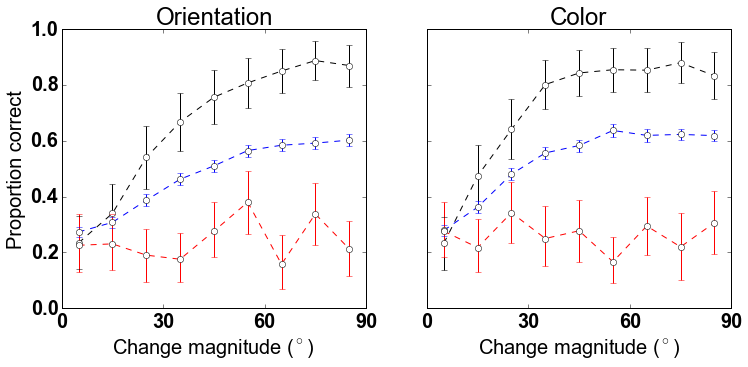

In [1020]:
"""
    Draw plots together w/ lab exp
"""
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
fig.set_size_inches(12, 5)

# Choose a mid-point of each bin for plotting
bins_loc = bins[:-1]+np.diff([bins[0],bins[1]])/2

# Lab exp
ax1.errorbar(bins_loc,df_mean.Correct.Ori,yerr=df_ste.Correct.Ori/2, color='black', fmt='o--', mfc='white')
ax2.errorbar(bins_loc,df_mean.Correct.Col,yerr=df_ste.Correct.Col/2, color='black', fmt='o--', mfc='white')
# Relevant feature
ax1.errorbar(bins_loc,mean_ro,yerr=[row1_ro,row2_ro], color='blue', fmt='o--', mfc='white')
ax2.errorbar(bins_loc,mean_rc,yerr=[row1_rc,row2_rc], color='blue', fmt='o--', mfc='white')
# Irrelevant feature
ax1.errorbar(bins_loc,mean_io,yerr=[row1_io,row2_io], color='red', fmt='o--', mfc='white')
ax2.errorbar(bins_loc,mean_ic,yerr=[row1_ic,row2_ic], color='red', fmt='o--', mfc='white')


# Axes
plt.ylim(0,1)
ax1.set_xticks([0,30,60,90])
ax2.set_xticks([0,30,60,90])

# Labels
ax1.set_ylabel('Proportion correct')
ax1.set_title('Orientation')
ax1.set_xlabel('Change magnitude ($^\circ$)')
ax2.set_title('Color')
ax2.set_xlabel('Change magnitude ($^\circ$)')

plt.show()

##2.6 Statistical analysis

In [1032]:
"""
    Compare lab vs. mturk subject: Mann Whitney U test
"""
print sp.stats.ttest_ind(df_mean.Correct.Ori,mean_ro)
print sp.stats.ttest_ind(df_mean.Correct.Col,mean_rc)

print sp.stats.mannwhitneyu(df_mean.Correct.Ori,mean_ro)
print sp.stats.mannwhitneyu(df_mean.Correct.Col,mean_rc)

(2.0521873362557037, 0.056886662178737106)
(2.1372858275712945, 0.048360223861414336)
(20.0, 0.038694305571003319)
(16.0, 0.017034597572071968)
